In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [17]:
def get_input(N, theta):

    theta_y = np.linspace(0, 180, N) # center of tuning curves 
    d = np.abs(theta - theta_y)      # distance to input theta
    sigma = 10                       # response width
    amp = 10                         # response amplitude

    y = amp * np.exp(-(d**2)/(2*sigma**2))

    return y

def weight_normalisation(weights, max_weights):
    return weights * max_weights / np.linalg.norm(weights)

def ori_matrix(x, mean, var):
    return stats.norm.pdf(x, mean, var) + stats.norm.pdf(x, mean+180, var) + stats.norm.pdf(x, mean-180, var) 

def nonlinearity(x):

    a = 1
    b = 0.25
    n = 2

    return a * np.maximum((x-b), 0)**n
    # return 1/(1+np.exp(-x))

def simulate(E_input, WE_init, WI_lateral_E_init, T):
    timesteps = int(T / delta_t)

    z = np.zeros(timesteps)
    z_lateral = np.zeros((N, timesteps))
    WE = np.zeros((N, timesteps))           # excitatory weights
    W_lateral = np.zeros((N, timesteps))    # lateral -> excitatory weights
    
    z[0] = np.random.randn()
    z_lateral[:, 0] = np.random.randn(N)
    WE[:, 0] = WE_init
    W_lateral[:, 0] = WI_lateral_E_init

    for i in range(timesteps - 1): 

        input_i = i % 180
        
        z_lateral[:, i + 1] = z_lateral[:, i] + (- z_lateral[:, i] + np.dot(W_lateral_FF, nonlinearity(E_input[:, input_i]))) * delta_t / tau

        z[i + 1] = z[i] + (- z[i] + np.dot(WE[:, i], nonlinearity(E_input[:, input_i])) - np.dot(W_lateral[:, i], nonlinearity(z_lateral[:, i]))) * delta_t / tau
        
        WE[:, i + 1] = WE[:, i] + (epsilon * nonlinearity(E_input[:, input_i]) * z[i]) * delta_t / tau_weights
        W_lateral[:, i + 1] = W_lateral[:, i] + (epsilon * np.outer(nonlinearity(z[i]), nonlinearity(z_lateral[:, i]))) * delta_t / tau_weights
        

        WE[:, i + 1] = weight_normalisation(WE[:, i + 1], max_WE)
        W_lateral[:, i + 1] = weight_normalisation(W_lateral[:, i + 1], max_WE)

    return z, WE[:, -1]

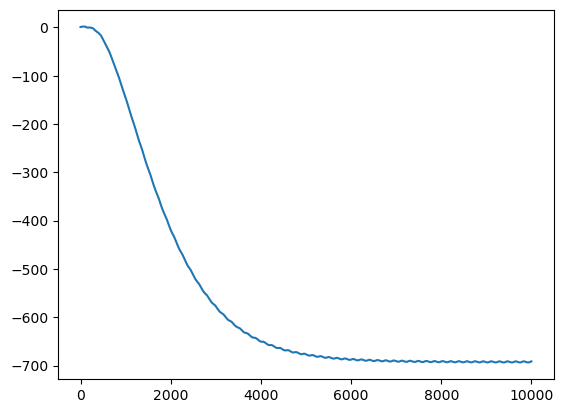

In [26]:
N = 20

T = 1000
delta_t = 0.1   
tau = 80
tau_weights = 100
epsilon = 10e-3
max_WE = 1
 
WE_init = np.random.randn(N)               # excitatory weights 
WI_lateral_E_init = np.random.randn(N)     # inhibitory weights 

E_input = np.array([get_input(N, theta) for theta in range(180)]).T

x = np.linspace(0, 180, N)
W_lateral_FF = np.zeros((N, N))
for i in range(N):
    W_lateral_FF[:, i] = ori_matrix(x, x[i], 20) * 20
    if i==5: W_lateral_FF[:, i] = 0

z_timecourse, WE_final = simulate(E_input, WE_init, WI_lateral_E_init, T)

plt.plot(z_timecourse)

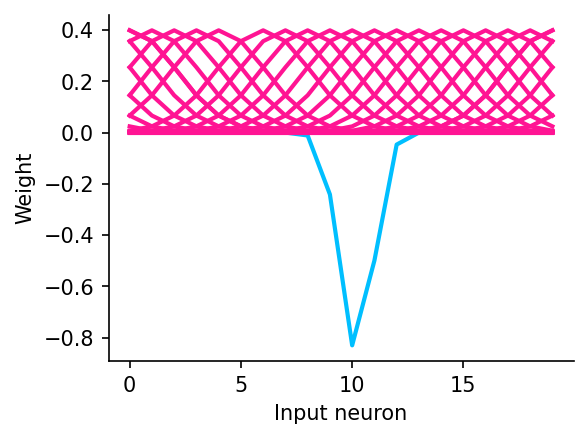

In [27]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

ax.plot(WE_final, lw=2, c='deepskyblue')
# ax.plot(-WI_final, lw=2, c='deeppink')
# ax.plot(W_lateral_FF, lw=2, c='navy')

for i in range(N):
    ax.plot(W_lateral_FF[:, i], lw=2, c='deeppink')

ax.set_ylabel('Weight')
ax.set_xlabel('Input neuron')
sns.despine()

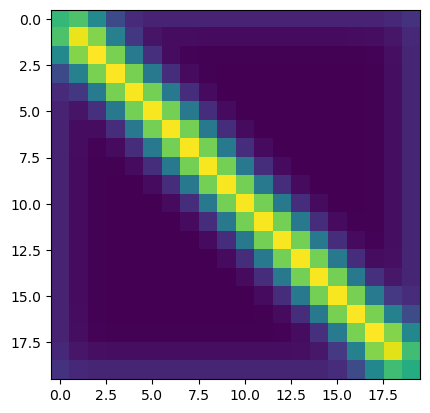

In [28]:
plt.imshow(np.cov(E_input))